In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class NodeLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(self.input_size, self.output_size)
        self.bias = np.random.randn(1,self.output_size)
        
        self.previous_grad_weights = 0
        self.previous_grad_bias = 0
        
    def forward(self,x):
        self.input = x
        output = np.dot(self.input, self.weights) + self.bias
        return output
        
    def backward(self, error, learning_rate, momentum):
        
        output = np.dot(error,self.weights.T)
        
        delta_weights = np.dot(self.input.T,error)
        m_delta_weights = momentum*self.previous_grad_weights + delta_weights*learning_rate
        self.weights -= m_delta_weights
        self.previous_grad_weights = m_delta_weights
        
        delta_bias = np.sum(error, axis = 0)
        m_delta_bias = momentum*self.previous_grad_bias + delta_bias*learning_rate
        self.bias -= m_delta_bias
        self.previous_grad_bias = m_delta_bias
        
        return output
        
        
  

In [4]:
class ReLu:
    def forward(self, x):
        self.input = x
        return np.maximum(self.input,0)
        
    def backward(self, error, learning_rate, momentum):
        relu_prime = np.where(self.input <= 0, 0, 1)
        return np.multiply(error, relu_prime)

In [5]:
class Tanh:
    def forward(self, x):
        self.input = x
        return np.tanh(self.input)
        
    def backward(self, error, learning_rate, momentum):
        tanh_prime = 1 - np.tanh(self.input)**2
        return np.multiply(error, tanh_prime)

In [6]:
class Dropout:
    def __init__(self, prob = 0.5):
        self.prob = prob
        
    def forward(self, x):
        self.drops = np.random.choice([0,1], size = x.shape, p = [self.prob, 1-self.prob])
        return np.multiply(x,self.drops)
    
    def backward(self, error, learning_rate, momentum):
        return np.multiply(self.drops, error)

In [7]:
def MSE(output, label):
    return np.mean(np.power(output-label,2))

In [8]:
def MSE_prime(output, label):
    return 2*(output - label)/output.shape[0]

In [9]:
def Softmax(x):
    shifted = x - (np.max(x, axis = 1, keepdims = True))
    exp = np.exp(shifted)+1e-200
    x = exp / np.sum(exp, axis = 1, keepdims = True)
    return x

In [10]:
def SoftmaxCrossEntropy(outputs, labels):
    outputs = Softmax(outputs)
    return CrossEntropyLoss(outputs, labels)

In [11]:
def SoftmaxCrossEntropy_prime(outputs, labels):
    outputs = Softmax(outputs)
    return outputs - labels

In [12]:
def CrossEntropyLoss(outputs, labels):
    return np.sum(np.multiply(-1*np.log(outputs), labels), axis = 1, keepdims = True)

In [13]:
def CrossEntropyLoss_prime(output, label):
    return np.multiply((-1/output), label)/output.shape[0]

In [14]:
class BatchIter:
    def __init__(self, batch_size, x_data, y_data, shuffle = True):
        self.batch_size = batch_size
        self.x_data = x_data
        self.y_data = y_data
        self.shuffle = shuffle
        self.index = 0
        if(batch_size >= len(self.x_data)):
            raise ValueError("Batch size must be less than size of data")
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if(self.index == 0 and self.shuffle):
            indexes = np.random.permutation(len(self.x_data))
            self.x_data = self.x_data[indexes]
            self.y_data = self.y_data[indexes]
            
        if(self.index > len(self.x_data)):
            self.index = 0
            raise StopIteration

        lower = self.index
        upper = self.index+self.batch_size
        
        if(upper > len(self.x_data)):
            result = (self.x_data[lower:], self.y_data[lower:])
        else:
            result = (self.x_data[lower:upper], self.y_data[lower:upper])
            
        self.index += self.batch_size
        
        if(result[0].size == 0):
            self.index = 0
            raise StopIteration
            
        return result
        
    

In [15]:
def get_accuracy(outputs, labels, show_fails = False, key = np.array([])):
    outputs_idx = np.argmax(outputs,axis = 1)
    labels_idx = np.argmax(labels, axis = 1)
    if(show_fails):
        outputs_val = key[outputs_idx]
        labels_val = key[labels_idx]
        compare = np.stack((outputs_val,labels_val,np.arange(labels_val.shape[0])),axis=1)
        boolean = (compare[:,0] != compare[:,1])
        compare = compare[boolean, :]
        print(compare[:10])
    correct = np.sum((outputs_idx == labels_idx))
    return correct/outputs.shape[0]*100

In [16]:
class Network:
    def __init__(self, layers, activation = 'relu'):
        
        self.network = []
        for i in range(len(layers)-1):
            self.network.append(NodeLayer(layers[i],layers[i+1]))
            if(i < len(layers)-2):
                if(activation == 'relu'):
                    self.network.append(ReLu())
                else:
                    self.network.append(Tanh())

        
    def forward(self,input_val):
        x = input_val
        for i in range(len(self.network)):
            x = self.network[i].forward(x)
        return x

    def backward(self, error_gradient, learning_rate, momentum = 0):
        e = error_gradient
        for i in range(len(self.network)):
            e = self.network[-(i+1)].backward(e, learning_rate, momentum)
            
            
    
    

In [17]:
def save_model(model):
    network = model.network
    trainable_params = []
    for i in network:
        if(isinstance(i,NodeLayer)):
            weights = i.weights.tolist()
            bias = i.bias.tolist()
            trainable_params.append([weights,bias])
        else:
            trainable_params.append([0])
            
    return trainable_params

In [18]:
def load_model(model, trainable_params):
    for i in range(len(trainable_params)):
        if(len(trainable_params[i])>1):
            model.network[i].weights = np.array(trainable_params[i][0])
            model.network[i].bias = np.array(trainable_params[i][1])

In [389]:
# ONE VAR DATA

In [1252]:
f = np.random.rand(8000)*2 - 1
l = f**3 + 1
f = f.reshape(250,32,1)
l = l.reshape(250,32,1)

In [1320]:
model = Network([1,32,32,1], activation = 'tanh')

epoch: 1    error: 4.697368149321392
epoch: 2    error: 0.3668529373666999
epoch: 3    error: 0.1658965034138509
epoch: 4    error: 0.11043091452041444
epoch: 5    error: 0.08626942726187048
epoch: 6    error: 0.07203181609022621
epoch: 7    error: 0.06187760275340783
epoch: 8    error: 0.053864958913754084
epoch: 9    error: 0.0472373193598473
epoch: 10    error: 0.041643951577172884
epoch: 11    error: 0.036886062431557204
epoch: 12    error: 0.032827687922217644
epoch: 13    error: 0.029363024860681302
epoch: 14    error: 0.02640404078746703
epoch: 15    error: 0.023875487728722757
epoch: 16    error: 0.021712588630329772
epoch: 17    error: 0.019859655118160336
epoch: 18    error: 0.01826901790699551
epoch: 19    error: 0.016900070736764194
epoch: 20    error: 0.015718378860834322
epoch: 21    error: 0.014694850676138122
epoch: 22    error: 0.013804981194155632
epoch: 23    error: 0.013028173996645435
epoch: 24    error: 0.012347143575371136
epoch: 25    error: 0.01174739573282382


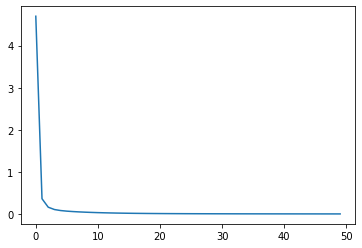

In [1321]:
epochs = 50

learning_rate = 1e-4

losses = []

for epoch in range(epochs):   
    
    error = 0
    
    for batch in range(f.shape[0]):
        features = f[batch]
        labels = l[batch]

        outputs = model.forward(features)
        loss = MSE(outputs, labels)
        error_gradient = MSE_prime(outputs, labels)
        model.backward(error_gradient, learning_rate)
        error+=loss
        
    losses.append(error/f.shape[0])
    print(f"epoch: {epoch+1}    error: {error/f.shape[0]}")


plt.plot(losses)
plt.show()

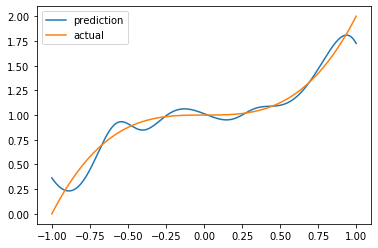

In [1322]:
x = np.arange(1001)/500 - 1
x = x.reshape(1001,1)
pred = model.forward(x)
y = x**3 + 1

plt.plot(x.flatten(), pred.flatten(), label='prediction')
plt.plot(x.flatten(), y.flatten(), label='actual')
plt.legend()
plt.show()

In [388]:
# LINEAR CATEGORICAL

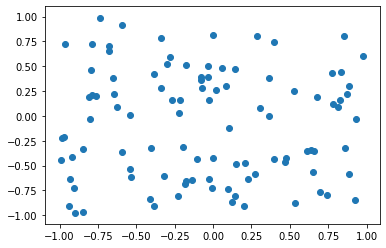

In [1437]:
f = np.random.rand(8000,2)*2 - 1
l = np.zeros((8000,2))
l[:, :] = [1,0]
l[f[:, 0] < f[:, 1]] = [0,1]

plt.scatter(f[:100,0], f[:100,1])

f = f.reshape(8000,1,2)
l = l.reshape(8000,1,2)

In [1438]:
model = Network([2,32,16,2], activation = 'tanh')

epoch: 1  error: 0.174 accuracy: 94.35
epoch: 2  error: 0.061 accuracy: 98.575
epoch: 3  error: 0.048 accuracy: 98.9875
epoch: 4  error: 0.041 accuracy: 99.1125
epoch: 5  error: 0.036 accuracy: 99.25
epoch: 6  error: 0.033 accuracy: 99.3125
epoch: 7  error: 0.030 accuracy: 99.35
epoch: 8  error: 0.028 accuracy: 99.4
epoch: 9  error: 0.026 accuracy: 99.425
epoch: 10  error: 0.025 accuracy: 99.4375
epoch: 11  error: 0.023 accuracy: 99.4875
epoch: 12  error: 0.022 accuracy: 99.525
epoch: 13  error: 0.021 accuracy: 99.5375
epoch: 14  error: 0.020 accuracy: 99.575
epoch: 15  error: 0.020 accuracy: 99.6


Text(0.5, 1.0, 'Accuracy')

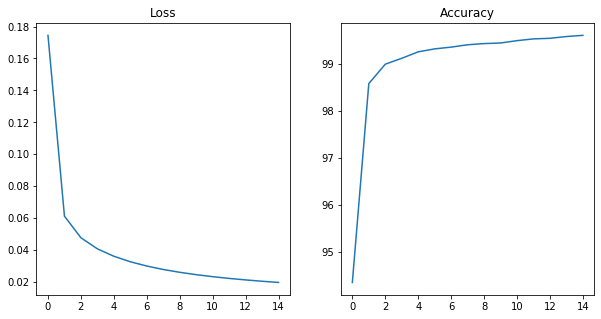

In [1439]:
epochs = 15

learning_rate = 1e-3

losses = []
accuracies = []

for epoch in range(epochs):   
    
    error = 0
    accuracy = 0
    
    for batch in range(f.shape[0]):
        features = f[batch]
        labels = l[batch]

        outputs = model.forward(features)

        loss = SoftmaxCrossEntropy(outputs, labels)
        acc = get_accuracy(Softmax(outputs), labels)
        
        error_gradient = SoftmaxCrossEntropy_prime(outputs, labels)
        model.backward(error_gradient, learning_rate)
        
        error+=np.mean(loss)
        accuracy+=acc
        
    losses.append(error/f.shape[0])
    accuracies.append(accuracy/f.shape[0])
    print(f"epoch: {epoch+1}  error: {(error/f.shape[0]):.3f} accuracy: {accuracy/f.shape[0]}")


fig, [p1,p2] = plt.subplots(1,2, figsize = (10,5))

p1.plot(losses)
p1.set_title("Loss")

p2.plot(accuracies)
p2.set_title("Accuracy")


In [ ]:
#MNIST HAND WRITTEN DIGETS DATASET

In [20]:
from keras.datasets import mnist
(train_x, train_y), (test_x, test_y) = mnist.load_data()
data_x = np.concatenate((train_x,test_x))
data_y = np.concatenate((train_y,test_y))

data_x = data_x/255

train_x = data_x[:48992]
train_y = data_y[:48992]

valid_x = data_x[48992:59496]
valid_y = data_y[48992:59496]

test_x = data_x[59496:]
test_y = data_y[59496:]

one_hot_train = np.zeros((len(train_y), 10))
one_hot_valid = np.zeros((len(valid_y), 10))
one_hot_test = np.zeros((len(test_y), 10))

for i in range(10):
    one_hot_train[train_y == i, i] = 1
    one_hot_valid[valid_y == i, i] = 1
    one_hot_test[test_y == i, i] = 1

train_y = one_hot_train
valid_y = one_hot_valid
test_y = one_hot_test

mnist_key = np.array([0,1,2,3,4,5,6,7,8,9])

In [21]:
mnist_model = Network([784,64,10], activation = 'relu')

In [22]:
epochs = 500
batch_size = 32
learning_rate = 1e-4
momentum = 0.8

losses = []
train_accuracies = []
valid_accuracies = []

batch_iter = iter(BatchIter(batch_size,train_x,train_y, shuffle = True))

saved_params = []
highest_acc = 0

for epoch in range(epochs):   
    
    error = 0
    accuracy = 0
    steps = 0
    
    for (features, labels) in batch_iter:
        features = features.reshape(len(features),784)

        outputs = mnist_model.forward(features)

        loss = SoftmaxCrossEntropy(outputs, labels)
        acc = get_accuracy(Softmax(outputs), labels)
        
        error_gradient = SoftmaxCrossEntropy_prime(outputs, labels)
        mnist_model.backward(error_gradient, learning_rate, momentum)

        error+=np.mean(loss)
        accuracy+=acc
        steps+=1
        
        
    valid_outputs = mnist_model.forward(valid_x.reshape(len(valid_x),784))
    valid_acc = get_accuracy(Softmax(valid_outputs), valid_y)
    if(valid_acc > highest_acc):
        highest_acc = valid_acc
        saved_params = save_model(mnist_model)
    
    
    losses.append(error/steps)
    train_accuracies.append(accuracy/steps)
    valid_accuracies.append(valid_acc)
    
    print(f"epoch: {epoch+1}  error: {(error/steps):.4f} train accuracy: {(accuracy/steps):.4f} validation accuracy: {valid_acc:.4f}")

epoch: 1  error: 5.6479 train accuracy: 71.4525 validation accuracy: 81.3976
epoch: 2  error: 1.5737 train accuracy: 81.3786 validation accuracy: 82.2258
epoch: 3  error: 1.0120 train accuracy: 82.7911 validation accuracy: 83.7776
epoch: 4  error: 0.7670 train accuracy: 83.7116 validation accuracy: 84.9581
epoch: 5  error: 0.6398 train accuracy: 84.4015 validation accuracy: 85.6721
epoch: 6  error: 0.5705 train accuracy: 85.0894 validation accuracy: 86.0149
epoch: 7  error: 0.5232 train accuracy: 85.6017 validation accuracy: 85.9768
epoch: 8  error: 0.4905 train accuracy: 86.1426 validation accuracy: 87.2144
epoch: 9  error: 0.4658 train accuracy: 86.6570 validation accuracy: 87.3762
epoch: 10  error: 0.4468 train accuracy: 87.1714 validation accuracy: 87.5952
epoch: 11  error: 0.4322 train accuracy: 87.3592 validation accuracy: 87.9474
epoch: 12  error: 0.4166 train accuracy: 87.8756 validation accuracy: 88.8709
epoch: 13  error: 0.4049 train accuracy: 88.1246 validation accuracy: 88.

epoch: 107  error: 0.1773 train accuracy: 94.6991 validation accuracy: 93.5072
epoch: 108  error: 0.1766 train accuracy: 94.6767 validation accuracy: 93.8024
epoch: 109  error: 0.1754 train accuracy: 94.7951 validation accuracy: 93.7548
epoch: 110  error: 0.1745 train accuracy: 94.8481 validation accuracy: 93.4025
epoch: 111  error: 0.1741 train accuracy: 94.8359 validation accuracy: 93.7262
epoch: 112  error: 0.1730 train accuracy: 94.8094 validation accuracy: 93.7643
epoch: 113  error: 0.1729 train accuracy: 94.8481 validation accuracy: 93.9071
epoch: 114  error: 0.1722 train accuracy: 94.9767 validation accuracy: 93.8309
epoch: 115  error: 0.1704 train accuracy: 94.9277 validation accuracy: 93.9166
epoch: 116  error: 0.1696 train accuracy: 94.9175 validation accuracy: 93.8500
epoch: 117  error: 0.1695 train accuracy: 94.9482 validation accuracy: 93.8690
epoch: 118  error: 0.1691 train accuracy: 94.9482 validation accuracy: 94.0023
epoch: 119  error: 0.1672 train accuracy: 95.0155 va

epoch: 211  error: 0.1192 train accuracy: 96.4076 validation accuracy: 94.2784
epoch: 212  error: 0.1191 train accuracy: 96.4239 validation accuracy: 94.6973
epoch: 213  error: 0.1181 train accuracy: 96.4913 validation accuracy: 94.7258
epoch: 214  error: 0.1172 train accuracy: 96.4851 validation accuracy: 94.7258
epoch: 215  error: 0.1174 train accuracy: 96.5545 validation accuracy: 94.5735
epoch: 216  error: 0.1170 train accuracy: 96.5423 validation accuracy: 94.4688
epoch: 217  error: 0.1159 train accuracy: 96.4953 validation accuracy: 94.4878
epoch: 218  error: 0.1156 train accuracy: 96.6117 validation accuracy: 94.4497
epoch: 219  error: 0.1159 train accuracy: 96.5076 validation accuracy: 94.6116
epoch: 220  error: 0.1149 train accuracy: 96.4851 validation accuracy: 94.5830
epoch: 221  error: 0.1147 train accuracy: 96.6199 validation accuracy: 94.7353
epoch: 222  error: 0.1148 train accuracy: 96.5545 validation accuracy: 94.7353
epoch: 223  error: 0.1141 train accuracy: 96.5647 va

epoch: 315  error: 0.0879 train accuracy: 97.4118 validation accuracy: 94.8401
epoch: 316  error: 0.0872 train accuracy: 97.4261 validation accuracy: 94.9353
epoch: 317  error: 0.0869 train accuracy: 97.3935 validation accuracy: 95.0019
epoch: 318  error: 0.0868 train accuracy: 97.4608 validation accuracy: 94.8305
epoch: 319  error: 0.0864 train accuracy: 97.4404 validation accuracy: 94.9924
epoch: 320  error: 0.0860 train accuracy: 97.4322 validation accuracy: 95.0876
epoch: 321  error: 0.0865 train accuracy: 97.3996 validation accuracy: 94.9353
epoch: 322  error: 0.0862 train accuracy: 97.4384 validation accuracy: 94.9924
epoch: 323  error: 0.0854 train accuracy: 97.4873 validation accuracy: 94.7544
epoch: 324  error: 0.0856 train accuracy: 97.4588 validation accuracy: 95.0971
epoch: 325  error: 0.0856 train accuracy: 97.4608 validation accuracy: 94.9067
epoch: 326  error: 0.0847 train accuracy: 97.5629 validation accuracy: 95.0209
epoch: 327  error: 0.0847 train accuracy: 97.5057 va

epoch: 419  error: 0.0668 train accuracy: 98.0629 validation accuracy: 95.0209
epoch: 420  error: 0.0670 train accuracy: 98.0282 validation accuracy: 95.2209
epoch: 421  error: 0.0666 train accuracy: 98.0323 validation accuracy: 95.3637
epoch: 422  error: 0.0663 train accuracy: 98.1283 validation accuracy: 95.3161
epoch: 423  error: 0.0666 train accuracy: 98.0691 validation accuracy: 95.3256
epoch: 424  error: 0.0661 train accuracy: 98.0711 validation accuracy: 95.2113
epoch: 425  error: 0.0662 train accuracy: 98.0854 validation accuracy: 95.2494
epoch: 426  error: 0.0660 train accuracy: 98.1426 validation accuracy: 95.2589
epoch: 427  error: 0.0657 train accuracy: 98.0834 validation accuracy: 95.3161
epoch: 428  error: 0.0653 train accuracy: 98.1568 validation accuracy: 95.2494
epoch: 429  error: 0.0653 train accuracy: 98.0976 validation accuracy: 95.3351
epoch: 430  error: 0.0650 train accuracy: 98.1528 validation accuracy: 95.3637
epoch: 431  error: 0.0649 train accuracy: 98.1119 va

test accuracy: 95.4018


Text(0.5, 1.0, 'Accuracy')

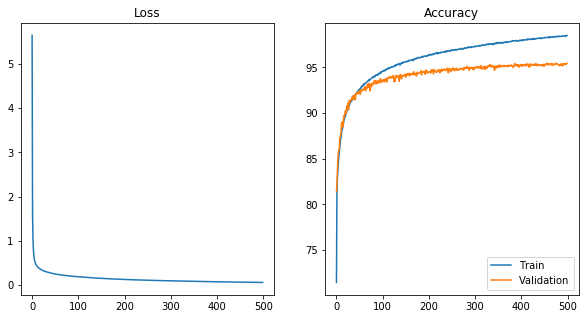

In [23]:
test_outputs = mnist_model.forward(test_x.reshape(len(test_x),784))
test_acc = get_accuracy(Softmax(test_outputs), test_y)
print(f"test accuracy: {test_acc:.4f}")

fig, [p1,p2] = plt.subplots(1,2, figsize = (10,5))
p1.plot(losses)
p1.set_title("Loss")

p2.plot(train_accuracies, label='Train')
p2.plot(valid_accuracies, label='Validation')
p2.legend()
p2.set_title("Accuracy")

In [24]:
load_model(mnist_model, saved_params)
test_outputs = mnist_model.forward(test_x.reshape(len(test_x),784))
test_acc = get_accuracy(Softmax(test_outputs), test_y)
print(f"loaded model test accuracy: {test_acc:.4f}")

loaded model test accuracy: 95.4018


Prediction: 1 with 99.94% confidence


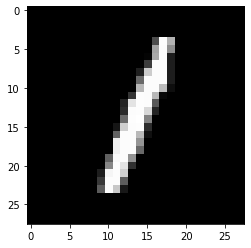

In [30]:
index = 209

outputs = Softmax(mnist_model.forward(test_x[index].flatten()))

value = np.argmax(outputs, axis = 1)[0]
confidence = np.amax(outputs,axis = 1)[0]*100
print(f"Prediction: {value} with {confidence:.2f}% confidence")

plt.imshow(test_x[index],cmap=plt.get_cmap('gray'))
plt.show()

In [31]:
get_accuracy(Softmax(mnist_model.forward(test_x.reshape(10504,784))),test_y, show_fails = True, key = mnist_key)

[[  9   0 157]
 [  2   0 185]
 [  6   5 205]
 [  5   9 223]
 [  0   2 224]
 [  2   5 230]
 [  1   5 235]
 [  5   2 238]
 [  8   3 239]
 [  2   5 251]]


95.4017517136329

In [ ]:
#MNIST FASHION DATASET

In [440]:
from keras.datasets import fashion_mnist
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()
data_x = np.concatenate((train_x,test_x))
data_y = np.concatenate((train_y,test_y))

data_x = data_x/255

train_x = data_x[:48992]
train_y = data_y[:48992]

valid_x = data_x[48992:59496]
valid_y = data_y[48992:59496]

test_x = data_x[59496:]
test_y = data_y[59496:]

one_hot_train = np.zeros((len(train_y), 10))
one_hot_valid = np.zeros((len(valid_y), 10))
one_hot_test = np.zeros((len(test_y), 10))

for i in range(10):
    one_hot_train[train_y == i, i] = 1
    one_hot_valid[valid_y == i, i] = 1
    one_hot_test[test_y == i, i] = 1

train_y = one_hot_train
valid_y = one_hot_valid
test_y = one_hot_test

fashion_key = np.array(["T-Shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle Boot"])

In [386]:
class Fashion_Network(Network):
    def __init__(self):
        self.network = [
            NodeLayer(784,128),
            ReLu(),
            NodeLayer(128,64),           
            ReLu(),
            NodeLayer(64,10)
        ]

fashion_model = Fashion_Network()

In [387]:
epochs = 200
learning_rate = 1e-4
batch_size = 32
momentum = 0.9

losses = []
train_accuracies = []
valid_accuracies = []

batch_iter = iter(BatchIter(batch_size,train_x,train_y, shuffle = True))

saved_params = []
highest_acc = 0

for epoch in range(epochs):   
    
    error = 0
    accuracy = 0
    steps = 0
    
    for (features, labels) in batch_iter:
        features = features.reshape(len(features),784)
        
        outputs = fashion_model.forward(features)
        
        loss = SoftmaxCrossEntropy(outputs, labels)
        acc = get_accuracy(Softmax(outputs), labels)
        
        error_gradient = SoftmaxCrossEntropy_prime(outputs, labels)
        fashion_model.backward(error_gradient, learning_rate, momentum)

        error+=np.mean(loss)
        accuracy+=acc
        steps+=1

    valid_outputs = fashion_model.forward(valid_x.reshape(len(valid_x),784))
    valid_acc = get_accuracy(Softmax(valid_outputs), valid_y)
    if(valid_acc > highest_acc):
        highest_acc = valid_acc
        saved_params = save_model(fashion_model)
        
    losses.append(error/steps)
    train_accuracies.append(accuracy/steps)
    valid_accuracies.append(valid_acc)
    
    print(f"epoch: {epoch+1}  error: {(error/steps):.4f} train accuracy: {(accuracy/steps):.4f} validation accuracy: {valid_acc:.4f}")

epoch: 1  error: 3.8652 train accuracy: 23.6855 validation accuracy: 28.9794
epoch: 2  error: 1.7815 train accuracy: 31.0479 validation accuracy: 34.2251
epoch: 3  error: 1.5603 train accuracy: 39.3370 validation accuracy: 42.8313
epoch: 4  error: 1.4257 train accuracy: 42.8866 validation accuracy: 44.8210
epoch: 5  error: 1.3915 train accuracy: 43.9500 validation accuracy: 42.6980
epoch: 6  error: 1.3211 train accuracy: 45.8299 validation accuracy: 47.1915
epoch: 7  error: 1.2915 train accuracy: 48.0180 validation accuracy: 46.7822
epoch: 8  error: 1.2446 train accuracy: 50.0469 validation accuracy: 47.9341
epoch: 9  error: 1.1825 train accuracy: 52.7086 validation accuracy: 55.2837
epoch: 10  error: 1.1229 train accuracy: 55.0008 validation accuracy: 57.4638
epoch: 11  error: 1.1033 train accuracy: 55.3539 validation accuracy: 55.6264
epoch: 12  error: 1.0602 train accuracy: 57.0113 validation accuracy: 52.9037
epoch: 13  error: 1.0573 train accuracy: 57.2502 validation accuracy: 59.

epoch: 107  error: 0.4952 train accuracy: 82.9564 validation accuracy: 79.9695
epoch: 108  error: 0.4907 train accuracy: 83.1360 validation accuracy: 81.1024
epoch: 109  error: 0.4884 train accuracy: 83.2769 validation accuracy: 81.4737
epoch: 110  error: 0.4886 train accuracy: 83.2605 validation accuracy: 81.5975
epoch: 111  error: 0.4877 train accuracy: 83.4095 validation accuracy: 81.3309
epoch: 112  error: 0.4832 train accuracy: 83.5116 validation accuracy: 80.8835
epoch: 113  error: 0.4841 train accuracy: 83.3810 validation accuracy: 81.0072
epoch: 114  error: 0.4835 train accuracy: 83.4993 validation accuracy: 80.7026
epoch: 115  error: 0.4804 train accuracy: 83.5932 validation accuracy: 81.2738
epoch: 116  error: 0.4783 train accuracy: 83.6586 validation accuracy: 81.8450
epoch: 117  error: 0.4788 train accuracy: 83.6075 validation accuracy: 80.2171
epoch: 118  error: 0.4776 train accuracy: 83.6749 validation accuracy: 79.9029
epoch: 119  error: 0.4739 train accuracy: 83.8668 va

epoch: 211  error: 0.3874 train accuracy: 87.0040 validation accuracy: 83.0731
epoch: 212  error: 0.3875 train accuracy: 86.9652 validation accuracy: 83.4920
epoch: 213  error: 0.3848 train accuracy: 87.0734 validation accuracy: 82.9494
epoch: 214  error: 0.3839 train accuracy: 87.1183 validation accuracy: 83.2064
epoch: 215  error: 0.3853 train accuracy: 87.0652 validation accuracy: 83.2826
epoch: 216  error: 0.3833 train accuracy: 87.1857 validation accuracy: 82.7113
epoch: 217  error: 0.3821 train accuracy: 87.2796 validation accuracy: 83.2540
epoch: 218  error: 0.3827 train accuracy: 87.1367 validation accuracy: 82.7970
epoch: 219  error: 0.3824 train accuracy: 87.2612 validation accuracy: 83.2540
epoch: 220  error: 0.3802 train accuracy: 87.1653 validation accuracy: 83.2635
epoch: 221  error: 0.3815 train accuracy: 87.2408 validation accuracy: 83.2730
epoch: 222  error: 0.3799 train accuracy: 87.3306 validation accuracy: 83.3397
epoch: 223  error: 0.3787 train accuracy: 87.3632 va

epoch: 315  error: 0.3275 train accuracy: 88.9247 validation accuracy: 84.0347
epoch: 316  error: 0.3276 train accuracy: 88.8839 validation accuracy: 83.6253
epoch: 317  error: 0.3263 train accuracy: 89.1145 validation accuracy: 83.7300
epoch: 318  error: 0.3253 train accuracy: 89.1186 validation accuracy: 84.0251
epoch: 319  error: 0.3247 train accuracy: 89.0288 validation accuracy: 84.1299
epoch: 320  error: 0.3242 train accuracy: 89.1839 validation accuracy: 83.6634
epoch: 321  error: 0.3230 train accuracy: 89.1717 validation accuracy: 84.1299
epoch: 322  error: 0.3242 train accuracy: 89.1064 validation accuracy: 83.2921
epoch: 323  error: 0.3231 train accuracy: 89.2166 validation accuracy: 83.8252
epoch: 324  error: 0.3216 train accuracy: 89.2533 validation accuracy: 83.9871
epoch: 325  error: 0.3220 train accuracy: 89.1635 validation accuracy: 84.1870
epoch: 326  error: 0.3210 train accuracy: 89.2105 validation accuracy: 83.8633
epoch: 327  error: 0.3207 train accuracy: 89.2431 va

epoch: 419  error: 0.2671 train accuracy: 90.5148 validation accuracy: 84.4726
epoch: 420  error: 0.2677 train accuracy: 90.6699 validation accuracy: 84.4631
epoch: 421  error: 0.2677 train accuracy: 90.5678 validation accuracy: 84.6059
epoch: 422  error: 0.2670 train accuracy: 90.6189 validation accuracy: 84.4821
epoch: 423  error: 0.2659 train accuracy: 90.7311 validation accuracy: 84.2822
epoch: 424  error: 0.2663 train accuracy: 90.6025 validation accuracy: 84.6059
epoch: 425  error: 0.2641 train accuracy: 90.8352 validation accuracy: 84.1870
epoch: 426  error: 0.2665 train accuracy: 90.6801 validation accuracy: 84.5107
epoch: 427  error: 0.2658 train accuracy: 90.7311 validation accuracy: 84.2631
epoch: 428  error: 0.2648 train accuracy: 90.7373 validation accuracy: 84.2536
epoch: 429  error: 0.2648 train accuracy: 90.7373 validation accuracy: 84.5107
epoch: 430  error: 0.2638 train accuracy: 90.6556 validation accuracy: 84.5963
epoch: 431  error: 0.2628 train accuracy: 90.8373 va

epoch: 523  error: 0.2328 train accuracy: 91.8762 validation accuracy: 84.2536
epoch: 524  error: 0.2324 train accuracy: 91.8681 validation accuracy: 84.5773
epoch: 525  error: 0.2314 train accuracy: 91.9334 validation accuracy: 84.8058
epoch: 526  error: 0.2314 train accuracy: 91.9926 validation accuracy: 84.7391
epoch: 527  error: 0.2302 train accuracy: 92.0191 validation accuracy: 84.4726
epoch: 528  error: 0.2310 train accuracy: 91.9170 validation accuracy: 84.5773
epoch: 529  error: 0.2286 train accuracy: 92.0130 validation accuracy: 84.6630
epoch: 530  error: 0.2311 train accuracy: 91.9293 validation accuracy: 84.5107
epoch: 531  error: 0.2303 train accuracy: 91.9905 validation accuracy: 84.5107
epoch: 532  error: 0.2296 train accuracy: 92.0028 validation accuracy: 84.8153
epoch: 533  error: 0.2290 train accuracy: 92.0701 validation accuracy: 84.2536
epoch: 534  error: 0.2298 train accuracy: 92.0334 validation accuracy: 84.4821
epoch: 535  error: 0.2294 train accuracy: 92.0661 va

epoch: 627  error: 0.2042 train accuracy: 92.8029 validation accuracy: 84.6725
epoch: 628  error: 0.2032 train accuracy: 93.0213 validation accuracy: 84.2917
epoch: 629  error: 0.2022 train accuracy: 93.0234 validation accuracy: 84.8629
epoch: 630  error: 0.2011 train accuracy: 92.9907 validation accuracy: 84.6820
epoch: 631  error: 0.2015 train accuracy: 93.0029 validation accuracy: 84.6249
epoch: 632  error: 0.2013 train accuracy: 93.1213 validation accuracy: 84.5297
epoch: 633  error: 0.2006 train accuracy: 92.9968 validation accuracy: 84.3964
epoch: 634  error: 0.2019 train accuracy: 93.0581 validation accuracy: 84.7582
epoch: 635  error: 0.2010 train accuracy: 93.0254 validation accuracy: 84.3107
epoch: 636  error: 0.1996 train accuracy: 93.1458 validation accuracy: 84.4059
epoch: 637  error: 0.2005 train accuracy: 93.0193 validation accuracy: 84.6820
epoch: 638  error: 0.1994 train accuracy: 93.0887 validation accuracy: 84.7201
epoch: 639  error: 0.1995 train accuracy: 93.0703 va

epoch: 731  error: 0.1792 train accuracy: 93.8500 validation accuracy: 84.6915
epoch: 732  error: 0.1798 train accuracy: 93.8623 validation accuracy: 84.6535
epoch: 733  error: 0.1777 train accuracy: 93.9092 validation accuracy: 84.9010
epoch: 734  error: 0.1777 train accuracy: 93.9521 validation accuracy: 84.7867
epoch: 735  error: 0.1769 train accuracy: 94.0439 validation accuracy: 84.3203
epoch: 736  error: 0.1786 train accuracy: 93.8725 validation accuracy: 84.5773
epoch: 737  error: 0.1788 train accuracy: 93.8398 validation accuracy: 84.6154
epoch: 738  error: 0.1786 train accuracy: 93.9215 validation accuracy: 84.4821
epoch: 739  error: 0.1763 train accuracy: 94.0358 validation accuracy: 84.6154
epoch: 740  error: 0.1759 train accuracy: 94.0562 validation accuracy: 84.5392
epoch: 741  error: 0.1776 train accuracy: 93.9480 validation accuracy: 84.7201
epoch: 742  error: 0.1764 train accuracy: 93.9419 validation accuracy: 84.7487
epoch: 743  error: 0.1770 train accuracy: 93.9970 va

epoch: 835  error: 0.1620 train accuracy: 94.6032 validation accuracy: 84.2251
epoch: 836  error: 0.1580 train accuracy: 94.7175 validation accuracy: 84.4916
epoch: 837  error: 0.1580 train accuracy: 94.6726 validation accuracy: 84.4440
epoch: 838  error: 0.1576 train accuracy: 94.6481 validation accuracy: 84.5107
epoch: 839  error: 0.1588 train accuracy: 94.6828 validation accuracy: 84.4535
epoch: 840  error: 0.1585 train accuracy: 94.6583 validation accuracy: 84.5487
epoch: 841  error: 0.1566 train accuracy: 94.7828 validation accuracy: 84.5011
epoch: 842  error: 0.1569 train accuracy: 94.7400 validation accuracy: 84.4916
epoch: 843  error: 0.1558 train accuracy: 94.8236 validation accuracy: 84.2536
epoch: 844  error: 0.1575 train accuracy: 94.6604 validation accuracy: 84.5583
epoch: 845  error: 0.1564 train accuracy: 94.8257 validation accuracy: 84.4345
epoch: 846  error: 0.1563 train accuracy: 94.6971 validation accuracy: 84.5583
epoch: 847  error: 0.1565 train accuracy: 94.7379 va

epoch: 939  error: 0.1435 train accuracy: 95.2400 validation accuracy: 84.0823
epoch: 940  error: 0.1407 train accuracy: 95.3339 validation accuracy: 84.3583
epoch: 941  error: 0.1386 train accuracy: 95.4360 validation accuracy: 84.4155
epoch: 942  error: 0.1388 train accuracy: 95.4319 validation accuracy: 84.3679
epoch: 943  error: 0.1415 train accuracy: 95.3911 validation accuracy: 84.1203
epoch: 944  error: 0.1402 train accuracy: 95.3584 validation accuracy: 84.6059
epoch: 945  error: 0.1405 train accuracy: 95.3707 validation accuracy: 84.4726
epoch: 946  error: 0.1384 train accuracy: 95.4931 validation accuracy: 84.1870
epoch: 947  error: 0.1380 train accuracy: 95.4850 validation accuracy: 84.3583
epoch: 948  error: 0.1372 train accuracy: 95.4584 validation accuracy: 84.3107
epoch: 949  error: 0.1376 train accuracy: 95.4707 validation accuracy: 84.1965
epoch: 950  error: 0.1371 train accuracy: 95.4278 validation accuracy: 84.2441
epoch: 951  error: 0.1368 train accuracy: 95.4380 va

test accuracy: 83.9966


Text(0.5, 1.0, 'Accuracy')

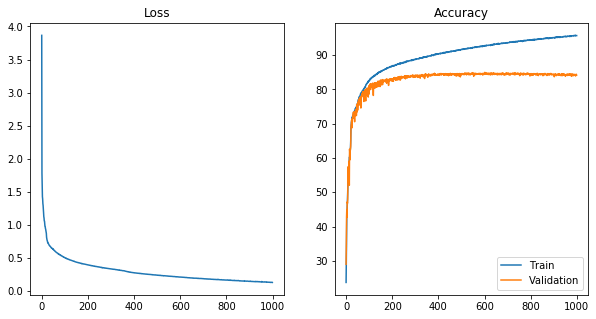

In [390]:
test_outputs = fashion_model.forward(test_x.reshape(test_x.shape[0],784))
test_acc = get_accuracy(Softmax(test_outputs), test_y)
print(f"test accuracy: {test_acc:.4f}")

fig, [p1,p2] = plt.subplots(1,2, figsize = (10,5))
p1.plot(losses)
p1.set_title("Loss")

p2.plot(train_accuracies, label='Train')
p2.plot(valid_accuracies, label='Validation')
p2.legend()
p2.set_title("Accuracy")

In [392]:
load_model(fashion_model, saved_params)
test_outputs = fashion_model.forward(test_x.reshape(test_x.shape[0],784))
test_acc = get_accuracy(Softmax(test_outputs), test_y)
print(f"loaded model test accuracy: {test_acc:.4f}")

loaded model test accuracy: 84.5773


Prediction: Ankle Boot with 75.04% confidence


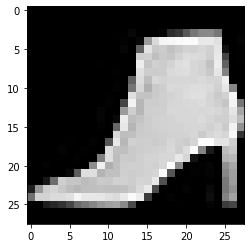

In [292]:
index = 8

outputs = Softmax(fashion_model.forward(test_x[index].flatten()))

value = fashion_key[np.argmax(outputs, axis = 1)[0]]
confidence = np.amax(outputs,axis = 1)[0]*100
print(f"Prediction: {value} with {confidence:.2f}% confidence")

plt.imshow(test_x[index],cmap=plt.get_cmap('gray'))
plt.show()

In [289]:
get_accuracy(Softmax(fashion_model.forward(test_x.reshape(10504,784))),test_y, show_fails = True, key = fashion_key)

[['Shirt' 'Dress' '0']
 ['Pullover' 'Shirt' '7']
 ['Shirt' 'T-Shirt' '13']
 ['Ankle Boot' 'Sneaker' '16']
 ['Pullover' 'T-Shirt' '23']
 ['Pullover' 'Shirt' '33']
 ['Shirt' 'Pullover' '40']
 ['Shirt' 'Coat' '47']
 ['T-Shirt' 'Shirt' '48']
 ['Coat' 'Shirt' '50']]


81.88309215536938